In [9]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def create_spectrogram(audio_file, image_file):
    # Create a new figure for the spectrogram
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    # Load the audio file using librosa
    y, sr = librosa.load(audio_file)

    # Compute the Mel spectrogram
    ms = librosa.feature.melspectrogram(y=y, sr=sr)

    # Convert to log scale (dB)
    log_ms = librosa.power_to_db(ms, ref=np.max)

    # Display the spectrogram on the axes
    librosa.display.specshow(log_ms, sr=sr, x_axis='time', y_axis='mel')

    # Save the figure to the specified image file
    fig.savefig(image_file)
    plt.close(fig)

def process_class_folders(classified_audio_folder, spectrogram_output_folder):
    # Iterate through each folder (class) inside the Classified_Audio_Files folder
    for class_folder in os.listdir(classified_audio_folder):
        class_path = os.path.join(classified_audio_folder, class_folder)

        # Skip hidden files or directories (such as .ipynb_checkpoints or other system files)
        if class_folder.startswith('.') or not os.path.isdir(class_path):
            continue

        # Define the target directory where the spectrograms will be saved
        class_spectrogram_folder = os.path.join(spectrogram_output_folder, class_folder)
        
        # Create the class-specific spectrogram folder if it doesn't exist
        if not os.path.exists(class_spectrogram_folder):
            os.makedirs(class_spectrogram_folder)

        # Iterate through all .wav files in the class folder
        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)
            
            # Skip non-WAV files
            if filename.endswith('.wav') and os.path.isfile(file_path):
                # Define the path for the spectrogram image
                spectrogram_path = os.path.join(class_spectrogram_folder, f"{os.path.splitext(filename)[0]}.png")
                
                # Generate and save the spectrogram
                create_spectrogram(file_path, spectrogram_path)

    print("Spectrogram generation complete!")

# Example usage:
classified_audio_folder = 'dataset/Classified_Audio_Files'
spectrogram_output_folder = 'dataset/Spectrograms'

# Call the function to process the class folders
process_class_folders(classified_audio_folder, spectrogram_output_folder)


Spectrogram generation complete!


In [1]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('dataset/Metadata/Metadata.csv')

# Create a mapping from 'className' to 'classID'
class_mapping = pd.Series(df['Class ID'].values, index=df['Class Name']).to_dict()

# Now, you can access the classID using className
print(class_mapping)


{'Fire': 1, 'Rain': 2, 'Thunderstorm': 3, 'WaterDrops': 4, 'Wind': 5, 'Silence': 6, 'TreeFalling': 7, 'Helicopter': 8, 'VehicleEngine': 9, 'Axe': 10, 'Chainsaw': 11, 'Generator': 12, 'Handsaw': 13, 'Firework': 14, 'Gunshot': 15, 'WoodChop': 16, 'Whistling': 17, 'Speaking': 18, 'Footsteps': 19, 'Clapping': 20, 'Insect': 21, 'Frog': 22, 'BirdChirping': 23, 'WingFlaping': 24, 'Lion': 25, 'WolfHowl': 26, 'Squirrel': 27}


In [2]:
from keras.preprocessing import image

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))
        
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

In [5]:
x = []
y = []
def process_spectrogram_folders(classified_spectrogram_folder):
    global x, y 
    # Iterate through each folder (class) inside the Classified_Audio_Files folder
    for class_folder in os.listdir(classified_spectrogram_folder):
        class_path = os.path.join(classified_spectrogram_folder, class_folder)
        label =  class_mapping.get(class_folder)-1
        images, labels = load_images_from_path(class_path, label)
        x += images
        y += labels
    print("Spectrogram generation complete!")
# Example usage:
classified_spectrogram_folder = 'dataset/Spectrograms'

process_spectrogram_folders(classified_spectrogram_folder)

Spectrogram generation complete!


In [6]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [50]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(27, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 128)       │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │      18,875,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 27)                  │          27,675 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,236,123 (73.38 MB)

 Trainable params: 19,236,123 (73.38 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), batch_size=10, epochs=10)

Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 106s 725ms/step - accuracy: 0.0435 - loss: 3.2491 - val_accuracy: 0.1743 - val_loss: 2.7822
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 102s 717ms/step - accuracy: 0.2144 - loss: 2.6378 - val_accuracy: 0.2977 - val_loss: 2.3585
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 100s 702ms/step - accuracy: 0.3602 - loss: 2.0594 - val_accuracy: 0.3849 - val_loss: 2.1411
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 99s 696ms/step - accuracy: 0.5366 - loss: 1.5379 - val_accuracy: 0.4359 - val_loss: 2.0695
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 100s 705ms/step - accuracy: 0.6231 - loss: 1.1486 - val_accuracy: 0.4293 - val_loss: 1.9321
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 103s 728ms/step - accuracy: 0.7426 - loss: 0.8136 - val_accuracy: 0.4688 - val_loss: 2.1596
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 106s 749ms/step - accuracy: 0.8180 - loss: 0.5040 - val_accuracy: 0.4836 - val_loss: 2.4005
Epoch 8/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 103s 724ms/step - accuracy: 0.8812 - 

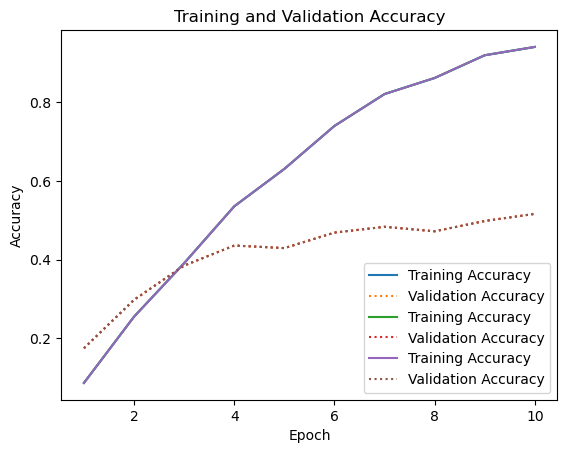

In [64]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [68]:
model.save('Trained_Model.keras')

Using Transfer Learning (MobileNetV2 requires less processing power and has a smaller memory footprint than CNNs such as ResNet50V2. That's why it is ideal for mobile devices. You can learn more about it in the Google AI blog.)

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x_train_norm = preprocess_input(np.array(x_train))
x_test_norm = preprocess_input(np.array(x_test))

train_features = base_model.predict(x_train_norm)
test_features = base_model.predict(x_test_norm)

MemoryError: Unable to allocate 814. MiB for an array with shape (1417, 224, 224, 3) and data type float32